# Solve Linear Elasticity problem (Hermann formulation), Version 2

In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# define geometry
geo = geometry.quarter_annulus() #.rotate_2d(pi)
#geo = geometry.disk().translate([0.3,0.3])

# define isogeometric Taylor-Hood discretization space
p = 3     # spline degree of velocity space
n_el = (50, 25)   # number of elements in y/x direction

# velocity space: degree p,   continuity p-2
# pressure space: degree p-1, continuity p-2
kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=2) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)

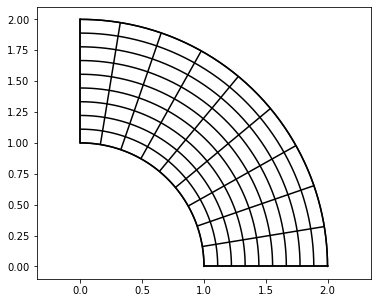

In [3]:
# undeformed quater annulus
figsize(6,5)
vis.plot_geo(geo, grid=2)

grid = geometry.outer_product(geometry.circular_arc(pi/2), geometry.line_segment(1, 2))
vis.plot_geo(grid)
axis('equal');

In [4]:
# assemble the System matrix
# A_grad = assemble.assemble('inner(grad(u), grad(v)) * dx', kvs_u, bfuns=[('u',2), ('v',2)], geo=geo)
A_div  = assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)

# Mu, lambda
Mu = 0.0006 #(shear modulus, rubber)
Lam= 0.3

def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(2,2)) # vector valued
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u,e_v) * dx)
    return vf

A_grad = assemble.assemble_vf(linelast_vf(2), kvs_u, geo=geo, symmetric=True)

A_c  = assemble.assemble('p * q * dx', kvs_p, bfuns=[('p',1,0), ('q',1,0)], geo=geo)/Lam

A_lin_el = scipy.sparse.bmat(
    [[A_grad, A_div.T],
     [A_div,  -A_c]], format='csr')

print(shape(A_grad))
print(shape(A_div))
print(shape(A_c))

Compiling /home/hilbert/heigl/.cache/pyiga/modules/mod9d98cb6b65ab8eed.pyx because it changed.
[1/1] Cythonizing /home/hilbert/heigl/.cache/pyiga/modules/mod9d98cb6b65ab8eed.pyx


In file included from /home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/hilbert/heigl/.cache/pyiga/modules/mod9d98cb6b65ab8eed.c:717:
/home/hilbert/heigl/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


(10608, 10608)
(1404, 10608)
(1404, 1404)


In [5]:
# define Dirichlet boundary conditions for lid-driven cavity problem
def g_lid(x, y):  return (0.0, (1-x)*(2-x)) # at boundary(x=1,2) = 0 
def g_zero(x, y): return (0.0, 0.0)

bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
        [('top', g_zero) , ('bottom', g_lid)]) #, ('left', g_zero), ('right',  g_zero)]) # left & right: neumann bc

N = np.prod(tuple(kv.numdofs for kv in kvs_u))

In [6]:
# surface integral: g*v ds
# TODO: assemble rhs (boundary functional g*v ds)

def g(x, y): return (0, 0.0003) # Neumann BC function
#gn  = assemble.assemble('g* v* ds', kvs_u, bfuns=[('v',2,0)], geo=geo)

def surface_functional_vf(dim):
    from pyiga.vform import VForm, grad, div, inner, ds
    import numpy as np
    V = VForm(dim, geo_dim=dim+1, arity=1) # arity: 1 for a linear functional and 2 for a bilinear form
    v = V.basisfuns(components=(2,2))
    print(v)
    g = V.input('g',shape=(2))
    V.add(inner(g,v) * ds) 
    return V

#g_n = assemble.assemble_vf(surface_functional_vf(1), kvs_u, bfuns=[('v',2)],args=['g'], geo=geo, boundary='left')
gn= assemble.assemble('inner(g,v)*ds', kvs_u, bfuns=[('v',2)], geo=geo, g=g, boundary='left')

g2= assemble.boundary_dofs(kvs_u,'left',ravel=True)

shape_a= shape(A_grad)[0]
vec= np.zeros(shape(A_lin_el)[0])
for i in range(len(g2)):
    vec[g2[i]]= gn[0,i,0]
    vec[g2[i]+shape_a//2]= gn[1,i,0]



In [7]:
# solve Stokes system with the given boundary conditions and 0 right-hand side
LS = assemble.RestrictedLinearSystem(A_lin_el, vec, bcs) # rhs = 0.0
u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u = LS.complete(u)

In [8]:
# split the solution into its components (velocity and pressure)
u1 = u[:N].reshape(m_u)
u2 = u[N:2*N].reshape(m_u)
U = np.stack((u1,u2), axis=-1)
prs = u[2*N:].reshape(m_p)

displ = geometry.BSplineFunc(kvs_u, U) # construct function with input arguments: coeff, basis functions (kvs), u_hat(x)
#pressure = geometry.BSplineFunc(kvs_p, prs)

In [9]:
# evaluate displacement and "pressure" over a grid in the parameter domain
xgrid = linspace(0, 1, 20)
xygrid = (xgrid, xgrid)

G = geo.grid_eval(xygrid)
dis = displ.grid_eval(xygrid)
#pre = pressure.grid_eval(xygrid)
#print(dis)

In [10]:
#s3 = G+dis
#shape(s3)

In [11]:
# interpolate displacement in [0,2] x [0,2] (physical coordinates) for streamplot
#grid_z= griddata(points, values, (grid_x, grid_y), method='cubic')

pgridx, pgridy = meshgrid(linspace(0,2,200), linspace(0,2,200), indexing='xy', sparse=True)
pdis = scipy.interpolate.griddata(G.reshape((-1,2)), dis.reshape((-1,2)), (pgridx,pgridy), method='cubic')

# mask out the inner radius
pdis[(pgridx**2 + pgridy**2) <= 1] = nan
#shape(pdis)

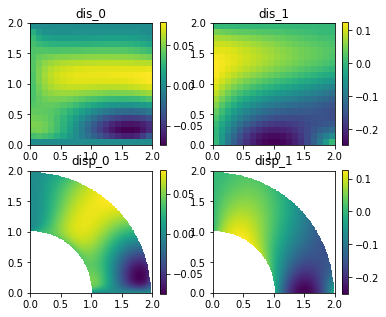

In [12]:
# plot interpolation results ('cubic')

plt.subplot(221)
plt.imshow(dis[...,0], extent=(0,2,0,2), origin='lower')
plt.title('dis_0')
colorbar();
plt.subplot(222)
plt.imshow(dis[...,1], extent=(0,2,0,2), origin='lower')
plt.title('dis_1')
colorbar();
plt.subplot(223)
plt.imshow(pdis[...,0], extent=(0,2,0,2), origin='lower')
plt.title('disp_0')
colorbar();
plt.subplot(224)
plt.imshow(pdis[...,1], extent=(0,2,0,2), origin='lower')
plt.title('disp_1')
colorbar();
plt.show()

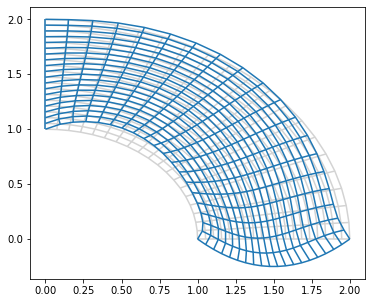

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

fig, ax = plt.subplots()

plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")

#plot_grid(s3[...,0],s3[...,1], ax=ax, color="C0")
plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="C0")
plt.show()

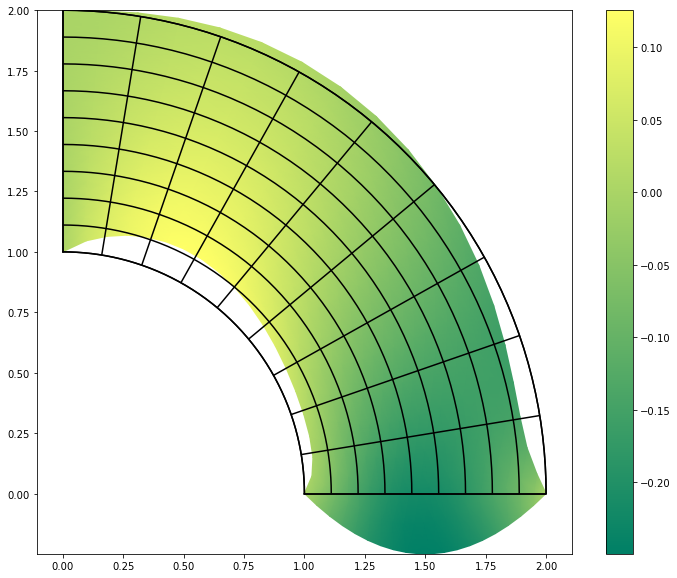

In [14]:
# plot undeformed quater annulus
figsize(12,10)
#plt.subplot(225)
# quater annulus
vis.plot_geo(geo, grid=2)

# inner grid of undeformed quater annulus
vis.plot_geo(grid)

#plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="black")

# colormesh w.r.t. displacement & deformed quater annulus
pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,1], cmap='summer', shading='gouraud');
colorbar();
axis('equal');


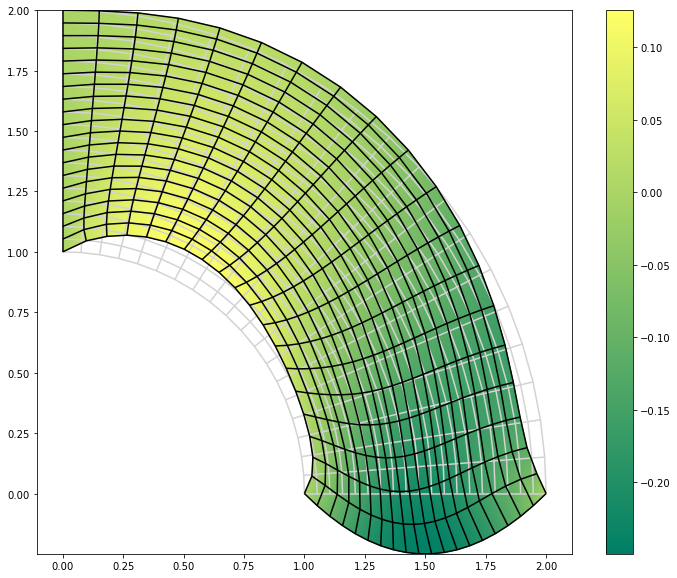

In [15]:
# plot deformation
#plt.subplot(226)
fig, ax = plt.subplots()

plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")



plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="black")

# colormesh w.r.t. displacement & deformed quater annulus
pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,1], cmap='summer', shading='gouraud');
colorbar();

#ax.streamplot(x_grid, y_grid, x_vec, y_vec, density=spacing)
#streamplot(pgridx[0,:], pgridy[:,0], pdef[...,0], pdef[...,1],
#           density=2, color='black', linewidth=0.3)
#plt.show()
axis('equal');